# Titanic Project Example Walk Through 
In this notebook, I hope to show how a data scientist would go about working through a problem. The goal is to correctly predict if someone survived the Titanic shipwreck. I thought it would be fun to see how well I could do in this competition without deep learning. 

## Overview 
### 1) Understand the shape of the data (Histograms, box plots, etc.)

### 2) Data Cleaning 

### 3) Data Exploration

### 4) Feature Engineering 

### 5) Data Preprocessing for Model

### 6) Basic Model Building 

### 7) Model Tuning 

### 8) Ensemble Modle Building 

### 9) Results 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


Here we import the data. For this analysis, we will be exclusively working with the Training set. We will be validating based on data from the training set as well. For our final submissions, we will make predictions based on the test set. 

In [2]:
training = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

training['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN
all_data = pd.concat([training,test])

%matplotlib inline
all_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

## Light Data Exploration
### 1) For numeric data 
* Made histograms to understand distributions 
* Corrplot 
* Pivot table comparing survival rate across numeric variables 


### 2) For Categorical Data 
* Made bar charts to understand balance of classes 
* Made pivot tables to understand relationship with survival 

In [3]:
#quick look at our data types & null counts 
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train_test   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [4]:
# to better understand the numeric data, we want to use the .describe() method. This gives us an understanding of the central tendencies of the data 
training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.0
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.0
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.0
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.0
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.0
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.0
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.0
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.0


In [5]:
#quick way to separate numeric columns
training.describe().columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'train_test'],
      dtype='object')

In [6]:
# look at numeric and categorical values separately 
df_num = training[['Age','SibSp','Parch','Fare']]
df_cat = training[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


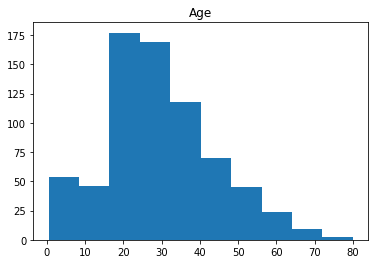

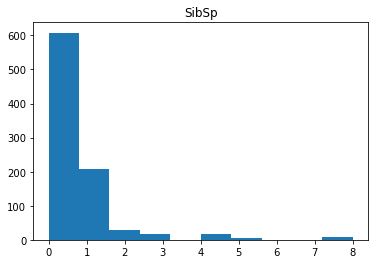

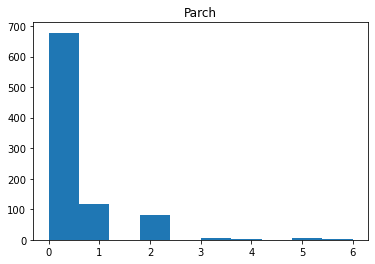

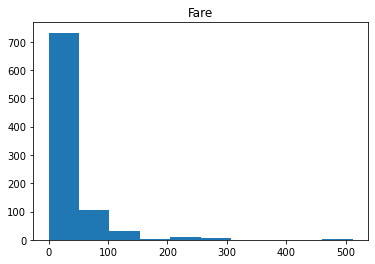

In [7]:
#distributions for all numeric variables 
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

Perhaps we should take the non-normal distributions and consider normalizing them?

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


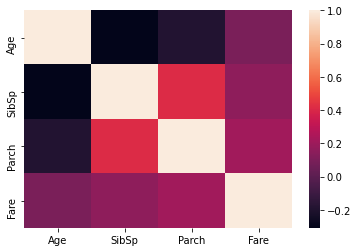

In [8]:
print(df_num.corr())
sns.heatmap(df_num.corr())

In [9]:
# compare survival rate across Age, SibSp, Parch, and Fare 
pd.pivot_table(training, index = 'Survived', values = ['Age','SibSp','Parch','Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


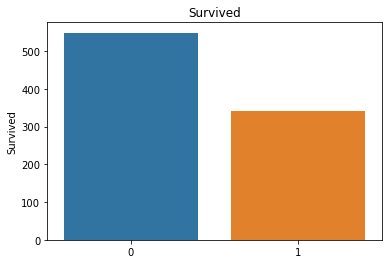

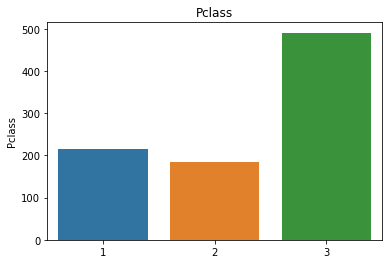

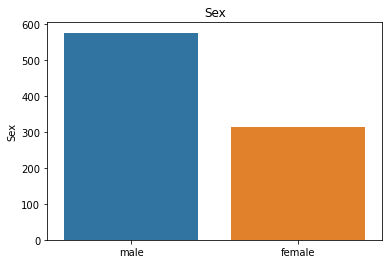

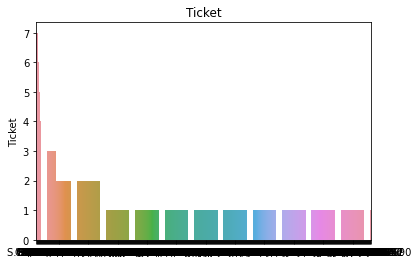

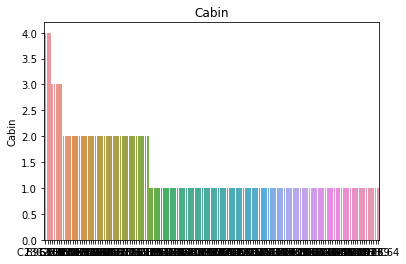

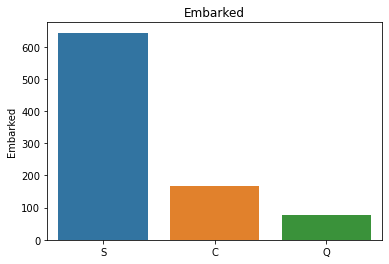

In [10]:
for i in df_cat.columns:
    sns.barplot(df_cat[i].value_counts().index,df_cat[i].value_counts()).set_title(i)
    plt.show()\
    

Cabin and ticket graphs are very messy. This is an area where we may want to do some feature engineering! 

In [11]:
# Comparing survival and each of these categorical variables 
print(pd.pivot_table(training, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(training, index = 'Survived', columns = 'Sex', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(training, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count'))

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

Sex       female  male
Survived              
0             81   468
1            233   109

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


## Feature Engineering 
### 1) Cabin - Simplify cabins (evaluated if cabin letter (cabin_adv) or the purchase of tickets across multiple cabins (cabin_multiple) impacted survival)

### 2) Tickets - Do different ticket types impact survival rates?

### 3) Does a person's title relate to survival rates? 

In [12]:
df_cat.Cabin
training['cabin_multiple'] = training.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
# after looking at this, we may want to look at cabin by letter or by number. Let's create some categories for this 
# letters 
# multiple letters 
training['cabin_multiple'].value_counts()

0    687
1    180
2     16
3      6
4      2
Name: cabin_multiple, dtype: int64

In [13]:
pd.pivot_table(training, index = 'Survived', columns = 'cabin_multiple', values = 'Ticket' ,aggfunc ='count')

cabin_multiple,0,1,2,3,4
Survived,,,,,
0,481.0,58.0,7.0,3.0,NaN
1,206.0,122.0,9.0,3.0,2.0


In [14]:
#creates categories based on the cabin letter (n stands for null)
#in this case we will treat null values like it's own category

training['cabin_adv'] = training.Cabin.apply(lambda x: str(x)[0])


In [15]:
#comparing surivial rate by cabin
print(training.cabin_adv.value_counts())
pd.pivot_table(training,index='Survived',columns='cabin_adv', values = 'Name', aggfunc='count')

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin_adv, dtype: int64


cabin_adv,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


In [16]:
#understand ticket values better 
#numeric vs non numeric 
training['numeric_ticket'] = training.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
training['ticket_letters'] = training.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)


In [17]:
training['numeric_ticket'].value_counts()

1    661
0    230
Name: numeric_ticket, dtype: int64

In [18]:
#lets us view all rows in dataframe through scrolling. This is for convenience 
pd.set_option("max_rows", None)
training['ticket_letters'].value_counts()


0            665
pc            60
ca            41
a5            21
stono2        18
sotonoq       15
scparis       11
wc            10
a4             7
soc            6
c              5
fcc            5
wep            3
pp             3
sopp           3
sotono2        2
scah           2
swpp           2
ppp            2
scow           1
as             1
casoton        1
fc             1
sca4           1
fa             1
sp             1
sop            1
sc             1
scahbasle      1
Name: ticket_letters, dtype: int64

In [19]:
#difference in numeric vs non-numeric tickets in survival rate 
pd.pivot_table(training,index='Survived',columns='numeric_ticket', values = 'Ticket', aggfunc='count')

numeric_ticket,0,1
Survived,,
0,142,407
1,88,254


In [20]:
#survival rate across different tyicket types 
pd.pivot_table(training,index='Survived',columns='ticket_letters', values = 'Ticket', aggfunc='count')

ticket_letters,0,a4,a5,as,c,ca,casoton,fa,fc,fcc,...,soc,sop,sopp,sotono2,sotonoq,sp,stono2,swpp,wc,wep
Survived,,,,,,,,,,,,,,,,,,,,,
0,410.0,7.0,19.0,1.0,3.0,27.0,1.0,1.0,1.0,1.0,...,5.0,1.0,3.0,2.0,13.0,1.0,10.0,NaN,9.0,2.0
1,255.0,NaN,2.0,NaN,2.0,14.0,NaN,NaN,NaN,4.0,...,1.0,NaN,NaN,NaN,2.0,NaN,8.0,2.0,1.0,1.0


In [21]:
#feature engineering on person's title 
training.Name.head(50)
training['name_title'] = training.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
#mr., ms., master. etc

In [22]:
training['name_title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Jonkheer          1
Lady              1
the Countess      1
Don               1
Mme               1
Capt              1
Ms                1
Sir               1
Name: name_title, dtype: int64

## Data Preprocessing for Model 
### 1) Drop null values from Embarked (only 2) 

### 2) Include only relevant variables (Since we have limited data, I wanted to exclude things like name and passanger ID so that we could have a reasonable number of features for our models to deal with) 
Variables:  'Pclass', 'Sex','Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'cabin_adv', 'cabin_multiple', 'numeric_ticket', 'name_title'

### 3) Do categorical transforms on all data. Usually we would use a transformer, but with this approach we can ensure that our traning and test data have the same colums. We also may be able to infer something about the shape of the test data through this method. I will stress, this is generally not recommend outside of a competition (use onehot encoder). 

### 4) Impute data with mean for fare and age (Should also experiment with median) 

### 5) Normalized fare using logarithm to give more semblance of a normal distribution 

### 6) Scaled data 0-1 with standard scaler 

(889,)

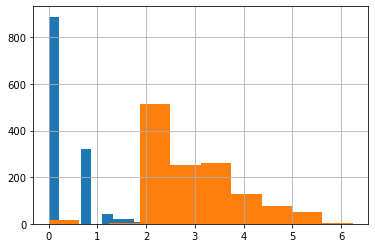

In [23]:
#create all categorical variables that we did above for both training and test sets 
all_data['cabin_multiple'] = all_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['cabin_adv'] = all_data.Cabin.apply(lambda x: str(x)[0])
all_data['numeric_ticket'] = all_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
all_data['ticket_letters'] = all_data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)
all_data['name_title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

#impute nulls for continuous data 
#all_data.Age = all_data.Age.fillna(training.Age.mean())
all_data.Age = all_data.Age.fillna(training.Age.median())
#all_data.Fare = all_data.Fare.fillna(training.Fare.mean())
all_data.Fare = all_data.Fare.fillna(training.Fare.median())

#drop null 'embarked' rows. Only 2 instances of this in training and 0 in test 
all_data.dropna(subset=['Embarked'],inplace = True)

#tried log norm of sibsp (not used)
all_data['norm_sibsp'] = np.log(all_data.SibSp+1)
all_data['norm_sibsp'].hist()

# log norm of fare (used)
all_data['norm_fare'] = np.log(all_data.Fare+1)
all_data['norm_fare'].hist()

# converted fare to category for pd.get_dummies()
all_data.Pclass = all_data.Pclass.astype(str)

#created dummy variables from categories (also can use OneHotEncoder)
all_dummies = pd.get_dummies(all_data[['Pclass','Sex','Age','SibSp','Parch','norm_fare','Embarked','cabin_adv','cabin_multiple','numeric_ticket','name_title','train_test']])

#Split to train test again
X_train = all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis =1)
X_test = all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis =1)


y_train = all_data[all_data.train_test==1].Survived
y_train.shape

In [24]:
# Scale data 
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age','SibSp','Parch','norm_fare']]= scale.fit_transform(all_dummies_scaled[['Age','SibSp','Parch','norm_fare']])
all_dummies_scaled

X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = all_data[all_data.train_test==1].Survived


## Model Building (Baseline Validation Performance)
Before going further, I like to see how various different models perform with default parameters. I tried the following models using 5 fold cross validation to get a baseline. With a validation set basline, we can see how much tuning improves each of the models. Just because a model has a high basline on this validation set doesn't mean that it will actually do better on the eventual test set. 

- Naive Bayes (72.6%)
- Logistic Regression (82.1%)
- Decision Tree (77.6%)
- K Nearest Neighbor (80.5%)
- Random Forest (80.6%)
- **Support Vector Classifier (83.2%)**
- Xtreme Gradient Boosting (81.8%)
- Soft Voting Classifier - All Models (82.8%)

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [26]:
#I usually use Naive Bayes as a baseline for my classification tasks 
gnb = GaussianNB()
cv = cross_val_score(gnb,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.66853933 0.70224719 0.75842697 0.74719101 0.73446328]
0.7221735542436362


In [27]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.8258427  0.80898876 0.80337079 0.82022472 0.85310734]
0.8223068621849807


In [28]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.8258427  0.80898876 0.80337079 0.82022472 0.85310734]
0.8223068621849807


In [29]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.75842697 0.74719101 0.8258427  0.74719101 0.8079096 ]
0.7773122579826065


In [30]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.75842697 0.74719101 0.8258427  0.74719101 0.8079096 ]
0.7773122579826065


In [31]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.76966292 0.79775281 0.80898876 0.82022472 0.85310734]
0.8099473116231829


In [32]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.79775281 0.79213483 0.83146067 0.79775281 0.85310734]
0.8144416936456548


In [33]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.80898876 0.79213483 0.84831461 0.73595506 0.82485876]
0.8020504030978227


In [34]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.80337079 0.79213483 0.84831461 0.73595506 0.82485876]
0.8009268075922046


In [35]:
svc = SVC(probability = True)
cv = cross_val_score(svc,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.85393258 0.82022472 0.8258427  0.80337079 0.86440678]
0.8335555132355742


In [36]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.82022472 0.81460674 0.85393258 0.79775281 0.81355932]
0.8200152351932963


In [37]:
#Voting classifier takes all of the inputs and averages the results. For a "hard" voting classifier each classifier gets 1 vote "yes" or "no" and the result is just a popular vote. For this, you generally want odd numbers
#A "soft" classifier averages the confidence of each of the models. If a the average confidence is > 50% that it is a 1 it will be counted as such
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svc',svc),('xgb',xgb)], voting = 'soft') 

In [38]:
cv = cross_val_score(voting_clf,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.83707865 0.81460674 0.8258427  0.79775281 0.84745763]
0.8245477051990097


In [39]:
voting_clf.fit(X_train_scaled,y_train)
y_hat_base_vc = voting_clf.predict(X_test_scaled).astype(int)
basic_submission = {'PassengerId': test.PassengerId, 'Survived': y_hat_base_vc}
base_submission = pd.DataFrame(data=basic_submission)
base_submission.to_csv('base_submission.csv', index=False)

## Model Tuned Performance 
After getting the baselines, let's see if we can improve on the indivdual model results!I mainly used grid search to tune the models. I also used Randomized Search for the Random Forest and XG boosted model to simplify testing time. 

|Model|Baseline|Tuned Performance|
|-----|--------|-----------------|
|Naive Bayes| 72.6%| NA|
|Logistic Regression| 82.1%| 82.6%|
|Decision Tree| 77.6%| NA|
|K Nearest Neighbor| 80.5%|83.0%|
|Random Forest| 80.6%| 83.6|
|Support Vector Classifier| 83.2%| 83.2%|
|Xtreme Gradient Boosting| 81.8%| 85.3%|


In [40]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [41]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [42]:
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_train_scaled,y_train)
clf_performance(best_clf_lr,'Logistic Regression')

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    1.8s


Logistic Regression
Best Score: 0.8279375357074843
Best Parameters: {'C': 1.623776739188721, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished


In [43]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_train_scaled,y_train)
clf_performance(best_clf_knn,'KNN')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.7s


KNN
Best Score: 0.8279375357074843
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    1.9s finished


In [44]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train_scaled,y_train)
clf_performance(best_clf_svc,'SVC')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:  3.2min finished


SVC
Best Score: 0.8335555132355742
Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [45]:
#Because the total feature space is so large, I used a randomized search to narrow down the paramters for the model. I took the best model from this and did a more granular search 
"""
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [100,500,1000], 
                                  'bootstrap': [True,False],
                                  'max_depth': [3,5,10,20,50,75,100,None],
                                  'max_features': ['auto','sqrt'],
                                  'min_samples_leaf': [1,2,4,10],
                                  'min_samples_split': [2,5,10]}
                                  
clf_rf_rnd = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 100, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf_rnd = clf_rf_rnd.fit(X_train_scaled,y_train)
clf_performance(best_clf_rf_rnd,'Random Forest')"""

"\nrf = RandomForestClassifier(random_state = 1)\nparam_grid =  {'n_estimators': [100,500,1000], \n                                  'bootstrap': [True,False],\n                                  'max_depth': [3,5,10,20,50,75,100,None],\n                                  'max_features': ['auto','sqrt'],\n                                  'min_samples_leaf': [1,2,4,10],\n                                  'min_samples_split': [2,5,10]}\n                                  \nclf_rf_rnd = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 100, cv = 5, verbose = True, n_jobs = -1)\nbest_clf_rf_rnd = clf_rf_rnd.fit(X_train_scaled,y_train)\nclf_performance(best_clf_rf_rnd,'Random Forest')"

In [46]:
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [400,450,500,550],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 20, 25],
                                  'max_features': ['auto','sqrt', 10],
                                  'min_samples_leaf': [2,3],
                                  'min_samples_split': [2,3]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train_scaled,y_train)
clf_performance(best_clf_rf,'Random Forest')

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 10.8min finished


Random Forest
Best Score: 0.8358027042468101
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 15, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 550}


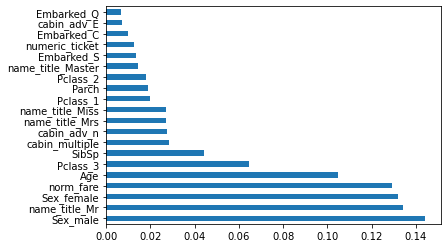

In [47]:
best_rf = best_clf_rf.best_estimator_.fit(X_train_scaled,y_train)
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [48]:
xgb = XGBClassifier(random_state = 1)

param_grid = {
    'n_estimators': [450,500,550],
    'colsample_bytree': [0.75,0.8,0.85],
    'max_depth': [None],
    'reg_alpha': [1],
    'reg_lambda': [2, 5, 10],
    'subsample': [0.55, 0.6, .65],
    'learning_rate':[0.5],
    'gamma':[.5,1,2],
    'min_child_weight':[0.01],
    'sampling_method': ['uniform']
}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train_scaled,y_train)
clf_performance(best_clf_xgb,'XGB')

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed:  6.3min finished


XGB
Best Score: 0.8515266933282548
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.5, 'max_depth': None, 'min_child_weight': 0.01, 'n_estimators': 550, 'reg_alpha': 1, 'reg_lambda': 10, 'sampling_method': 'uniform', 'subsample': 0.65}


In [49]:
y_hat_xgb = best_clf_xgb.best_estimator_.predict(X_test_scaled).astype(int)
xgb_submission = {'PassengerId': test.PassengerId, 'Survived': y_hat_xgb}
submission_xgb = pd.DataFrame(data=xgb_submission)
submission_xgb.to_csv('xgb_submission3.csv', index=False)

## Model Additional Ensemble Approaches 
1) Experimented with a hard voting classifier of three estimators (KNN, SVM, RF) (81.6%)

2) **Experimented with a soft voting classifier of three estimators (KNN, SVM, RF) (82.3%) (Best Performance)**

3) Experimented with soft voting on all estimators performing better than 80% except xgb (KNN, RF, LR, SVC) (82.9%)

4) Experimented with soft voting on all estimators including XGB (KNN, SVM, RF, LR, XGB) (83.5%)

In [50]:
best_lr = best_clf_lr.best_estimator_
best_knn = best_clf_knn.best_estimator_
best_svc = best_clf_svc.best_estimator_
best_rf = best_clf_rf.best_estimator_
best_xgb = best_clf_xgb.best_estimator_

voting_clf_hard = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc)], voting = 'hard') 
voting_clf_soft = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc)], voting = 'soft') 
voting_clf_all = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), ('lr', best_lr)], voting = 'soft') 
voting_clf_xgb = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), ('xgb', best_xgb),('lr', best_lr)], voting = 'soft')

print('voting_clf_hard :',cross_val_score(voting_clf_hard,X_train,y_train,cv=5))
print('voting_clf_hard mean :',cross_val_score(voting_clf_hard,X_train,y_train,cv=5).mean())

print('voting_clf_soft :',cross_val_score(voting_clf_soft,X_train,y_train,cv=5))
print('voting_clf_soft mean :',cross_val_score(voting_clf_soft,X_train,y_train,cv=5).mean())

print('voting_clf_all :',cross_val_score(voting_clf_all,X_train,y_train,cv=5))
print('voting_clf_all mean :',cross_val_score(voting_clf_all,X_train,y_train,cv=5).mean())

print('voting_clf_xgb :',cross_val_score(voting_clf_xgb,X_train,y_train,cv=5))
print('voting_clf_xgb mean :',cross_val_score(voting_clf_xgb,X_train,y_train,cv=5).mean())


voting_clf_hard : [0.79213483 0.81460674 0.82022472 0.79775281 0.83615819]
voting_clf_hard mean : 0.8121754586427983
voting_clf_soft : [0.78651685 0.8258427  0.81460674 0.79775281 0.85310734]
voting_clf_soft mean : 0.8155652891512728
voting_clf_all : [0.80898876 0.83146067 0.8258427  0.80898876 0.85875706]
voting_clf_all mean : 0.8268075922046595
voting_clf_xgb : [0.82022472 0.8258427  0.83146067 0.80898876 0.8700565 ]
voting_clf_xgb mean : 0.8313146702215451


In [51]:
#in a soft voting classifier you can weight some models more than others. I used a grid search to explore different weightings
#no new results here
params = {'weights' : [[1,1,1],[1,2,1],[1,1,2],[2,1,1],[2,2,1],[1,2,2],[2,1,2]]}

vote_weight = GridSearchCV(voting_clf_soft, param_grid = params, cv = 5, verbose = True, n_jobs = -1)
best_clf_weight = vote_weight.fit(X_train_scaled,y_train)
clf_performance(best_clf_weight,'VC Weights')
voting_clf_sub = best_clf_weight.best_estimator_.predict(X_test_scaled)


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   20.9s finished


VC Weights
Best Score: 0.83244461372437
Best Parameters: {'weights': [2, 2, 1]}


In [52]:
#Make Predictions 
voting_clf_hard.fit(X_train_scaled, y_train)
voting_clf_soft.fit(X_train_scaled, y_train)
voting_clf_all.fit(X_train_scaled, y_train)
voting_clf_xgb.fit(X_train_scaled, y_train)

best_rf.fit(X_train_scaled, y_train)
y_hat_vc_hard = voting_clf_hard.predict(X_test_scaled).astype(int)
y_hat_rf = best_rf.predict(X_test_scaled).astype(int)
y_hat_vc_soft =  voting_clf_soft.predict(X_test_scaled).astype(int)
y_hat_vc_all = voting_clf_all.predict(X_test_scaled).astype(int)
y_hat_vc_xgb = voting_clf_xgb.predict(X_test_scaled).astype(int)

In [53]:
#convert output to dataframe 
final_data = {'PassengerId': test.PassengerId, 'Survived': y_hat_rf}
submission = pd.DataFrame(data=final_data)

final_data_2 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_hard}
submission_2 = pd.DataFrame(data=final_data_2)

final_data_3 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_soft}
submission_3 = pd.DataFrame(data=final_data_3)

final_data_4 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_all}
submission_4 = pd.DataFrame(data=final_data_4)

final_data_5 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_xgb}
submission_5 = pd.DataFrame(data=final_data_5)

final_data_comp = {'PassengerId': test.PassengerId, 'Survived_vc_hard': y_hat_vc_hard, 'Survived_rf': y_hat_rf, 'Survived_vc_soft' : y_hat_vc_soft, 'Survived_vc_all' : y_hat_vc_all,  'Survived_vc_xgb' : y_hat_vc_xgb}
comparison = pd.DataFrame(data=final_data_comp)

In [54]:
#track differences between outputs 
comparison['difference_rf_vc_hard'] = comparison.apply(lambda x: 1 if x.Survived_vc_hard != x.Survived_rf else 0, axis =1)
comparison['difference_soft_hard'] = comparison.apply(lambda x: 1 if x.Survived_vc_hard != x.Survived_vc_soft else 0, axis =1)
comparison['difference_hard_all'] = comparison.apply(lambda x: 1 if x.Survived_vc_all != x.Survived_vc_hard else 0, axis =1)


In [55]:
comparison.difference_hard_all.value_counts()

0    410
1      8
Name: difference_hard_all, dtype: int64

In [56]:
#prepare submission files 
submission.to_csv('submission_rf.csv', index =False)
submission_2.to_csv('submission_vc_hard.csv',index=False)
submission_3.to_csv('submission_vc_soft.csv', index=False)
submission_4.to_csv('submission_vc_all.csv', index=False)
submission_5.to_csv('submission_vc_xgb2.csv', index=False)